In [4]:
import d2lzh as d2l
from mxnet import gluon, image, nd
from mxnet.gluon import data as gdata, utils as gutils
import os
import sys
import tarfile

In [7]:
def read_voc_images(root, is_train=True):
    txt_fname = '%s/ImageSets/Segmentation/%s' % (root, 'train.txt' if is_train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
        features, labels = [None] * len(images), [None] * len(images)
    for i, fname in enumerate(images):
        features[i] = image.imread('%s/JPEGImages/%s.jpg' % (root, fname))
        labels[i] = image.imread('%s/SegmentationClass/%s.png' % (root, fname))
    
    return features, labels

root = '/home/huqian/data/datasets/VOCdevkit/VOC2012'
train_features, train_labels = read_voc_images(root)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bfe124cd0>,
      dtype=object)

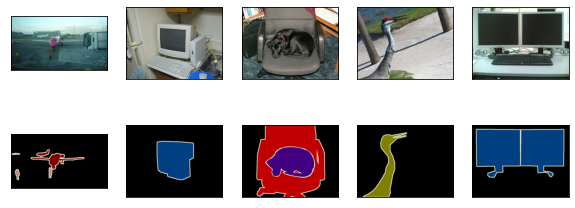

In [10]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]
d2l.show_images(imgs, 2, n)

In [11]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
[0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
[64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
[64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
[0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
[0, 64, 128]]
# 该常量已保存在d2lzh包中方便以后使用
VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
'diningtable', 'dog', 'horse', 'motorbike', 'person',
'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

colormap2label = nd.zeros(256 ** 3)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

# 本函数已保存在d2lzh包中方便以后使用
def voc_label_indices(colormap, colormap2label):
    colormap = colormap.astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [12]:
y = voc_label_indices(train_labels[0], colormap2label)
y[105:115, 130:140], VOC_CLASSES[1]

(
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 <NDArray 10x10 @cpu(0)>,
 'aeroplane')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bfe5d6550>,
      dtype=object)

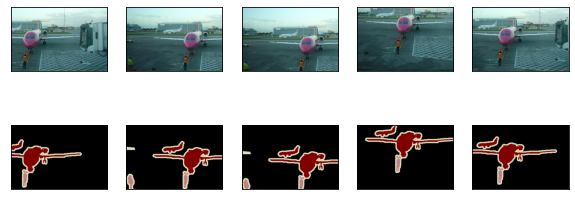

In [15]:
# 本函数已保存在d2lzh包中方便以后使用
def voc_rand_crop(feature, label, height, width):
    feature, rect = image.random_crop(feature, (width, height))
    label = image.fixed_crop(label, *rect)
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)
d2l.show_images(imgs[::2] + imgs[1::2], 2, n)

In [17]:
# 本类已保存在d2lzh包中方便以后使用
class VOCSegDataset(gdata.Dataset):
    def __init__(self, is_train, crop_size, voc_dir, colormap2label):
        self.rgb_mean = nd.array([0.485, 0.456, 0.406])
        self.rgb_std = nd.array([0.229, 0.224, 0.225])
        self.crop_size = crop_size
        features, labels = read_voc_images(root=voc_dir, is_train=is_train)
        self.features = [self.normalize_image(feature)
                         for feature in self.filter(features)]
        self.labels = self.filter(labels)
        self.colormap2label = colormap2label
        print('read ' + str(len(self.features)) + ' examples')
                         
    def normalize_image(self, img):
        return (img.astype('float32') / 255 - self.rgb_mean) / self.rgb_std
                         
    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[0] >= self.crop_size[0] and
            img.shape[1] >= self.crop_size[1])]
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],*self.crop_size)
        return (feature.transpose((2, 0, 1)),
                voc_label_indices(label, self.colormap2label))
    def __len__(self):
        return len(self.features)

In [19]:
crop_size = (320, 480)
voc_train = VOCSegDataset(True, crop_size, root, colormap2label)
voc_test = VOCSegDataset(False, crop_size, root, colormap2label)

read 1114 examples
read 1078 examples


In [20]:
batch_size = 64
num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(voc_train, batch_size, shuffle=True,last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(voc_test, batch_size, last_batch='discard',num_workers=num_workers)

In [25]:
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


In [28]:
pretrained_net = model_zoo.vision.resnet18_v2(pretrained=True)
pretrained_net.features[-4:], pretrained_net.output

(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True, global_pool=True, pool_type=avg, layout=NCHW)
   (3): Flatten
 ),
 Dense(512 -> 1000, linear))

In [44]:
import d2lzh as d2l
from mxnet import gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, model_zoo, nn
import numpy as np
import sys

net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)



In [45]:
X = nd.random.uniform(shape=(1, 3, 320, 480))
net(X).shape

(1, 512, 10, 15)

In [46]:
num_classes = 21
net.add(nn.Conv2D(num_classes, kernel_size=1),
    nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,
    strides=32))

In [47]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),dtype='float32')
        weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

In [48]:
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)
conv_trans.initialize(init.Constant(bilinear_kernel(3, 3, 4)))

In [53]:
img = image.imread('/home/huqian/data/datasets/VOCdevkit/VOC2012/JPEGImages/2008_004201.jpg')
X = img.astype('float32').transpose((2, 0, 1)).expand_dims(axis=0) / 255
Y = conv_trans(X)
out_img = Y[0].transpose((1, 2, 0))

input image shape: (498, 500, 3)
output image shape: (996, 1000, 3)


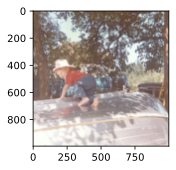

In [54]:
d2l.set_figsize()
print('input image shape:', img.shape)
d2l.plt.imshow(img.asnumpy());
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img.asnumpy())

In [55]:
crop_size, batch_size, colormap2label = (320, 480), 32, nd.zeros(256**3)
for i, cm in enumerate(d2l.VOC_COLORMAP):
    colormap2label[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i

num_workers = 0 if sys.platform.startswith('win32') else 4
train_iter = gdata.DataLoader(
d2l.VOCSegDataset(True, crop_size, root, colormap2label), batch_size,
    shuffle=True, last_batch='discard', num_workers=num_workers)
test_iter = gdata.DataLoader(
    d2l.VOCSegDataset(False, crop_size, root, colormap2label), batch_size,
    last_batch='discard', num_workers=num_workers)

read 1114 examples
read 1078 examples


In [59]:
ctx = d2l.try_all_gpus()
loss = gloss.SoftmaxCrossEntropyLoss(axis=1)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1,'wd': 1e-3})
d2l.train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=5)

ValueError: Cannot reset context for Parameter 'conv4_weight' because it has not been initialized.

In [60]:
def predict(img):
    X = test_iter._dataset.normalize_image(img)
    X = X.transpose((2, 0, 1)).expand_dims(axis=0)
    pred = nd.argmax(net(X.as_in_context(ctx[0])), axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    colormap = nd.array(d2l.VOC_COLORMAP, ctx=ctx[0], dtype='uint8')
    X = pred.astype('int32')
    return colormap[X, :]

In [61]:
test_images, test_labels = d2l.read_voc_images(is_train=False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 480, 320)
    X = image.fixed_crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X, pred, image.fixed_crop(test_labels[i], *crop_rect)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n)

FileNotFoundError: [Errno 2] No such file or directory: '../data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt'

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model = torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=21)

# 加载数据
transform = transforms.Compose(
    [
        transforms.Resize(500,500),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
target_transform = transforms.Compose(
    [
        transforms.Resize(500,500),
        transforms.ToTensor()
    ])

root = '/home/huqian/data/datasets'
train_set = torchvision.datasets.VOCSegmentation(root,year='2012',image_set='train',download=True,transform=transform,target_transform=target_transform)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=2)



Using downloaded and verified file: /home/huqian/data/datasets/VOCtrainval_11-May-2012.tar


In [ ]:
for idx,(imgs,targets) in enumerate(train_loader):
    data = imgs[0].clone().cpu().numpy()
    data = np.transpose(data,(1,2,0))
    plt.figure(figsize=(10,10))
    plt.imshow(data)
    pred = model(imgs)
    print(pred)

    break
